In [5]:
import sympy as sy
sy.init_printing(use_latex=True)

import numpy as np

import pandas as pd

import scipy as sc
import scipy.linalg as LA
import scipy.integrate as integrate

import matplotlib.pyplot as plt

import copy

import math

import vpython as vp
vec = vp.vector

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2. Abgabe aus dem Fach Modellbildung und Simulation - Klassische Mechanik 2

## Keplerproblem

Zwei Massen $M$ und $m$, die den Abstand $r$ zueinander besitzen, ziehen sich gegenseitig mit der Kraft
$$ \vec{F}_G = -G\frac{Mm}{r^2}\vec{e}_r $$
an. $G$ ist die universelle Gravitationskonstante.

In [6]:
x = sy.symbols('x')

### 1.
Im File Sat.txt sind die Umlaufzeiten $T$ und mittleren Radien $r$ der Umlaufbahnen von vier Satelliten angegeben (die einen Asteroiden umkreisen). Zeigen Sie, dass sich die Datein mit der Form $T=Cr^n$ beschreiben lassen. Bestimmen Sie $n$ und $C$, indem sie Sie die Daten logarithmisch auftragen. Schätzen Sie den fehlenden Radius ab.

Aufgabe herausfinden was C und n sein können.

Die Umlaufzeit ist gegeben durch $a= \omega^2r = (\frac{2\pi}{T})^2r$

['T in a ', 'r in Gm ']
[['T in a ', 'r in Gm '], ['0.44', '0.088'], ['1.61', '0.208'], ['3.88', '0.374'], ['6.20', '?'], ['7.89', '0.600']]
{'T in a ': [0.44, 1.61, 3.88, 6.2, 7.89], 'r in Gm ': [0.088, 0.208, 0.374, x, 0.6]}
[0.44, 1.61, 3.88, 7.89]
[0.088, 0.208, 0.374, 0.6]


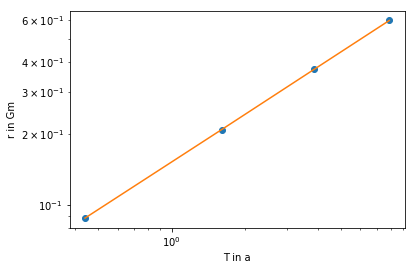

In [7]:
with open("Sat.txt", "r") as f:
    sat = [line.split() for line in f]
header_ = sat[0]
header = []
h_str1 = ''
h_str2 = ''
for i in range(0, 3):
    h_str1 += header_[i] + ' '
    h_str2 += header_[i+3] + ' '
header = [h_str1, h_str2]
sat[0] = header
print(header)
print(sat)
sat_data = {}
for s in range(1, len(sat)):
    for n in range(0, len(sat[s])):
        if sat[s][n] == '?':
            sat[s][n] = x
        else:
            sat[s][n] = float(sat[s][n])
sat_data = {sat[0][i]: [ line[i] for line in sat[1:] ]  for i in range(len(sat[0]))}
print(sat_data)
xs = sat_data['T in a '][0:3]
xs.append(sat_data['T in a '][4])
print(xs)

ys = sat_data['r in Gm '][0:3]
ys.append(sat_data['r in Gm '][4])
print(ys)
plt.loglog(xs, ys, 'o')
plt.loglog(xs, ys)
plt.xlabel('T in a')
plt.ylabel('r in Gm')
plt.show()

$\mathrm{ln}(a) + b \mathrm{ln}(x) = \mathrm{ln}(y) $
Berechnung Potenzfunktion : $y = ax^b$

### 2.
Schreiben Sie ein Programm, das die Differentialgleichung
$$ m\ddot{\vec{r}} = -G\frac{Mm}{r^3}\vec{r} $$
löst und visualisieren Sie die Bahnkurve der Erde um die Sonne. Verwenden sie als Anfangsgeschwindigkeit $(0.0, 29.8)*10^3m/s$ und den Anfangsort der Erde $(1.4960, 0.0)*10^{11}m$ (Die Sonne ruhe anfänglich im Urspung). Überprüfen Sie die Impuls-, Drehimpuls- und Energieerhaltung numerisch.

Zunächst wird die Gleichung $ m\ddot{\vec{r}} = -G\frac{Mm}{r^3}\vec{r} $ umgestellt.

In [8]:
M, m, r, G, vr, t = sy.symbols('M, m, r, G, \\vec{r}, t')
ddr = sy.symbols('\ddot{\\vec{r}}', function=True)

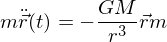

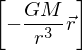

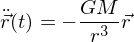

In [9]:
gl = sy.Eq(m*ddr(t), -G*((M*m)/r**3)*vr)
display(gl)
gl = sy.solve(gl, ddr(t))
display(gl)
gl2 = sy.Eq(ddr(t), gl[0])
display(gl2)

Nach der Umstellung wird diese Gleichung verwendet um die Bahngleichung numerisch zu berechnen.

Hier wird das Runge-Kutta-Verfahren implementiert, hier mit der kleine Abänderung das auch die Massen und das Gewicht übergeben zu können um diese in die Differentialgleichung einsetzen zu können.

In [10]:
def rk4(y, t, m, h, ode):
    """
    :param y: letzter berechneter Wert zum Zeitpunkt t
    :param t: Zeitpunkt des zuletzt berechneten Schrittes
    :param m: Massen der Planeten
    :parma h: Schrittweite
    :param ode: zu lösende Dgl
    :return: ynew Lsg zu Zeitpunkt t+h
    """
    k1 = np.array(ode(t, y, m))
    k2 = np.array(ode(t+(h/2), y+ (h/2)*k1, m))
    k3 = np.array(ode(t+(h/2), y+(h/2)*k2, m))
    k4 = np.array(ode(t+h, y+h*k3, m))
    ynew = y + h*(k1+2*k2+2*k3+k4)/6
    return ynew

Mit `ODEPlanets` wird die rechte Seite der Dgl berechnet. Diese Gleichung kann Theoretisch auf mehr Planeten angewandt werden. Für die Sterne wird jedoch eine andere Berechnung angewandt um die Python Routine zur Berechnung von Dgl's benutzen zu können.

In [11]:
def ODEPlanets(t, y, masses):
    '''
    berechnet die rechte Seite der Differentialgleichung 
    Zunächst kommen alle Variablen (x,y,vx,vy) für den ersten Planeten, dann alle 4 für den zweiten,... 
    :param t: aktueller zeitpunkt
    :param y: aktueller y-Wert (n Komponenten)
    :param masses: Massen der Planeten
    :return: rechte Seite f der Dgl. y'=f(t,y)
    '''

    G = 6.674E-11 #Gravitationskonstante
    y = np.array(y)
    y = y.reshape(-1, 4)
    rs = []
    dy = []
    for i in range(0, len(y)):
        F_i = np.array([0., 0.])
        rs.append(np.array([y[i][0], y[i][1]]))
        r_i = np.array([y[i][0], y[i][1]])
        for j in range(0, len(y)):
            if i != j:
                r_j = np.array([y[j][0], y[j][1]])
                m_j = masses[j]
                dist = r_i-r_j
                if LA.norm(dist) > 0:
                    F_i += m_j *((dist)/(LA.norm(dist))**3)
                else:
                    F_i += np.array([0., 0.])
        ddr_i = -G*F_i
        dy.append(y[i][2])
        dy.append(y[i][3])
        dy.append(ddr_i[0])
        dy.append(ddr_i[1])
    return dy

Die Funktion `integrateall` dient der Berechnung einer Dgl vom Startzeitpunkt t0 zum bis zum Zeitpunkt tend.

In [12]:
def integrateall(method, ode, masses, y0, t0, tend, N, intermediate=False):
    """
    :param method: Enschrittverfahren
    :param ode: Rechte seite der Dgl
    :param y0: Anfangswert
    :param t0: Anfangszeitpunkt
    :param tend: Endzeitpunkt
    :param N: Anzahl der Schritte
    :param intermediate: True, wenn zum Plotten der Lösung auch die Ergebnisse der Zwischenschritte zurückgegeben werden sollen
    :return: Lösung am Endzeitpunkt (bzw. zusätzlich an den Zwischenzetpunkten, wenn intermediate =True)
    """
    yvals = [y0]
    space =  np.linspace(t0, round(tend, 5), num=N, retstep=True, dtype=float)
    tvals = space[0]
    h = space[1]
    y = y0
    for ts in tvals:
        y = method(y, ts, masses, h, ode)
        yvals.append(y)
    del yvals[-1]
    yend=yvals[-1]
    if intermediate:
        return np.array(yvals), tvals
    else:
        return yend

Die Funktion `planetCoordinates` berechnet die Koordinaten der Planeten mit der Funktion `integrate all` und ordnet diese in ein Dictionary ein.

In [13]:
def planetCoordinates(planets, t0, tend, N):
    """
    :param planets: Dictionary der Planeten mit Anfangsort und -geschwindigkeit,
                    sowie die Masse des Planeten
    :param t0: Anfangszeitpunkt zur Berechnung
    :param tend: Endzeitpunkt
    :param N: Anzahl der Schritte die berechnet werden sollen
    :return: alle berechneten Werte in einer Liste, Liste der Zeitpunkt, Koordinaten der Planeten in einem Dictionary
    """
    planet_n = []
    tvals, h = np.linspace(t0, tend, N, retstep=True)
    coordinates = {}
    y_planets = []
    masses = []
    for planet in planets:
        planet_n.append(planet)
        x_s = planets[planet]['pos'][0]
        y_s = planets[planet]['pos'][1]
        dx_s = planets[planet]['vel'][0]
        dy_s = planets[planet]['vel'][1]
        y_planets.append(x_s)
        y_planets.append(y_s)
        y_planets.append(dx_s)
        y_planets.append(dy_s)
        masses.append(planets[planet]['mass'])
        coordinates[planet] = {'x':[], 'y':[]}
    y_list, t_list = integrateall(rk4, ODEPlanets, masses, y_planets, t0, tend, N, intermediate=True)
    for y_step in y_list:
        y_shaped = y_step.reshape(-1, 4)
        for i in range(0, len(y_shaped)):
            list_c = coordinates[planet_n[i]]['x']
            list_c.append(y_shaped[i][0])
            list_c = coordinates[planet_n[i]]['y']
            list_c.append(y_shaped[i][1])
    
    return y_list, t_list, coordinates

Die Funktion `planetsPlot` bekommt alle wichtigen Werte zu berechnen und fügt sie in ein Dictionary um sie an `planetCoordinates` weiterzugeben. Daraufhin plottet die Funktion die Bahnkurven, mit den Koordinaten aus der Funktion `planetCoordinates`.

In [14]:
def planetsPlot(names, pos, vel, masses, t, N):
    """
    :param names: Namen der Planeten in einer Liste
    :param pos: Anfangsorte der Planeten in einer Liste
    :param vel: Anfangsgeschwindigkeiten der Planeten in einer Liste
    :param masses: Massen der Planeten
    :param t: Anfangs- und Endzeitpunkt in einer Liste
    :param N: Anzahl der Schritte
    :return: List aller berechneten Werte, Dictionary der Koordinaten
    """
    planets = {}
    for i in range(0, len(pos)):
        planets[names[i]] = {'pos' : pos[i], 'vel': vel[i], 'mass': Massen[i]}
    t0 = t[0]
    tend = t[1]
    y_list, t_list, coordinates = planetCoordinates(planets, t0, tend, N)
    for st in coordinates:
        r = np.random.rand()
        g = np.random.rand()
        b = np.random.rand()
        xs = coordinates[st]['x']
        ys = coordinates[st]['y']
        plt.plot(xs[0], ys[0], 'x', color=[r, g, b], label='Anfangspunkt'+st)
        plt.plot(xs, ys, color=[r, g, b], label=st)
        plt.plot(xs[-1], ys[-1], 'o', color=[r, g, b], label='Endpunkt'+st)

    plt.legend()
    return y_list, t_list, coordinates

Die Funktion `conservation` bekommt die berechneten Werte für die Orte und Geschwindigkeiten der Planeten und berechnet mit diesen die Impulse, Drehimpulse und Energie(kinetische und potenzielle) um mit diesen die Erhaltung dieser zu untersuchen.

In [15]:
def conservation(y, ts):
    """
    :param y: Liste der Berechneten Werte (Orte und Koordinaten der Planeten)
    :param ts: Liste der Zeitpunkte der berechneten Werte
    :return: Dictionary mit Impuls-, Drehimpuls- und Energiewerten zur unterschunung der Erhaltung
    """
    xs = ts
    Pe = []
    Ps = []
    P = []
    Le = []
    Ls = []
    L = []
    Ekin = []
    Epot = []
    E = []
    for y_ in y:
        o_s = y_[0:2]
        g_s = y_[2:4]
        o_e = y_[4:6]
        g_e = y_[6:8]
        
        # Abstand
        r = (o_e-o_s)
        
        #Abstand zum Drehpunkt
        r_e = (m_s/(m_e+m_s))*r
        r_s = r-r_e
        
        #Impulserhaltung
        P_e = m_e*g_e
        Pe.append(P_e)
        P_e_g = P_e[0]+P_e[1]
        P_s = m_s*g_s
        Ps.append(P_s)
        P_s_g = P_s[0]+P_s[1]
        P.append(P_e_g+P_s_g)
        
        #Drehimpulserhaltung
        alpha_e = np.arccos(np.dot(g_e, r_e)/(LA.norm(g_e)*LA.norm(r_e)))
        L_e = m_e*LA.norm(g_e)*LA.norm(r_e)*math.sin(alpha_e)
        Le.append(L_e)
        alpha_s = np.arccos(np.dot(g_s, r_s)/(LA.norm(g_s)*LA.norm(r_s)))
        L_s = m_s*LA.norm(g_s)*LA.norm(r_s)*math.sin(alpha_s)
        Ls.append(L_s)
        L.append(L_e+L_s)
        
        #Energieerhaltung
        E_kin = m_e*((LA.norm(g_e))**2)/2+m_s*((LA.norm(g_s))**2)/2
        Ekin.append(E_kin)
        E_pot = -G_val*m_e*m_s/LA.norm(r)
        Epot.append(E_pot)
        E.append(E_kin+E_pot)

    result = {'x': ts, 'Impulserhaltung': [Pe, Ps, P], 'Drehimpulserhaltung': [Le, Ls, L], 'Energieerhaltung': [Ekin, Epot, E]}
    return result

Die Funktion `plot_momentum` plottet die Impulse zu den Zeitpunkten. Zunächst die der Erde daraufhin die der Sonne und zuletzt die Werte der beiden addiert. Die Impulserhaltung kann dann graphisch untersuch werden. Die Impulse bleiben über den Zeitraum erhalten, wenn 

In [44]:
def plot_momentum(result):
    
    xs = result['x']
    imp = result['Impulserhaltung']
    Pe = imp[0]
    Ps = imp[1]
    P = imp[2]

    #plt.plot(xs, np.array(Pe)[:, 0], color='#b7d5fd', label='Impuls in x Richtung Erde')
    #plt.plot(xs, np.array(Pe)[:, 1], color='#004a85', label='Impuls in y Richtung Erde')
    #plt.legend()
    #plt.show()

    #plt.plot(xs, np.array(Ps)[:, 0], color='#feff83', label='Impuls in x Richtung Sonne')
    #plt.plot(xs, np.array(Ps)[:, 1], color='#e1e000', label='Impuls in y Richtung Sonne')
    #plt.legend()
    #plt.show()

    Pe_s = [Pe[i][0]+Pe[i][1] for i in range(0, len(Pe))]
    plt.plot(xs, Pe_s, color='#0000ff', label='Impuls Erde')
    plt.legend()
    plt.show()
    Ps_s = [Ps[i][0]+Ps[i][1] for i in range(0, len(Ps))]
    plt.plot(xs, Ps_s, color='#ffff00', label='Impuls Sonne')
    plt.legend()
    plt.show()

    plt.plot(xs, P, color='#00ff00')
    plt.title('Impuls gesamt')
    plt.show()

In [45]:
def plot_angular_momentum(result):
    xs = result['x']
    dImp = result['Drehimpulserhaltung']
    Le = dImp[0]
    Ls = dImp[1]
    L = dImp[2]
    plt.plot(xs, Le, color='#0000ff')
    plt.title('Drehimpuls Erde')
    plt.show()
    plt.plot(xs, Ls, color='#ffff00')
    plt.title('Drehimpuls Sonne')
    plt.show()
    plt.plot(xs, L, color='#00ff00')
    plt.title('Drehimpuls gesamt')
    plt.show()

In [46]:
def plot_energie(result):
    xs = result['x']
    En = result['Energieerhaltung']
    Ekin = En[0]
    Epot = En[1]
    E = En[2]
    plt.plot(xs, Ekin, color='#ff00ff')
    plt.title('Kinetische Energie')
    plt.show()
    plt.plot(xs, Epot, color='#ff004e')
    plt.title('Potenzielle Energie')
    plt.show()
    plt.plot(xs, E, color='#00ff00')
    plt.title('Energie gesamt')
    plt.show()

In [47]:
G_val = 6.674E-11

m_e = 5.972e24
a_ort_e = np.array([149.6e11, 0.])
a_gesch_e = np.array([0.0, 2.978e3])

m_s = 1.989e30
a_ort_s = np.array([0, 0.])
a_gesch_s = np.array([0., 0.])

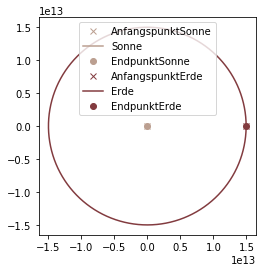

In [48]:
Namen = ['Sonne', 'Erde']
Orte = [a_ort_s, a_ort_e]
Gesch = [a_gesch_s, a_gesch_e]
Massen = [m_s, m_e]
ys, ts, c = planetsPlot(Namen, Orte, Gesch, Massen, [0, 3.154e10], 10000)
plt.axis('scaled')
plt.show()

In [49]:
result = conservation(ys, ts)

C:\Users\ALI\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in double_scalars


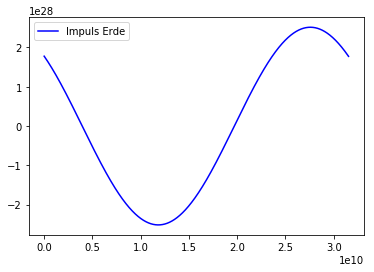

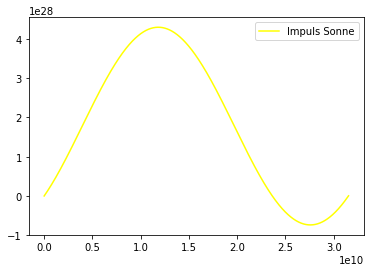

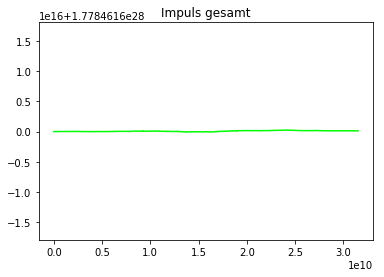

In [50]:
plot_momentum(result)

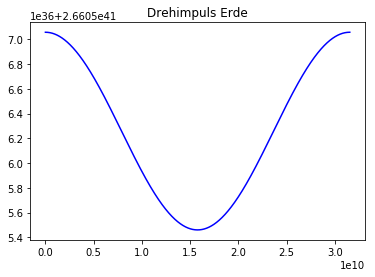

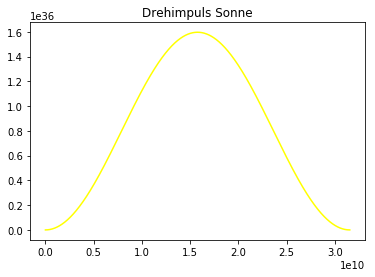

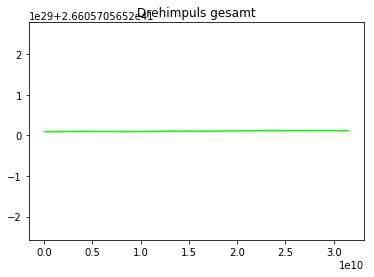

In [51]:
plot_angular_momentum(result)

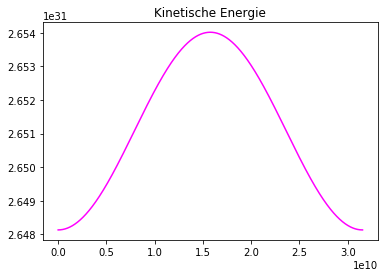

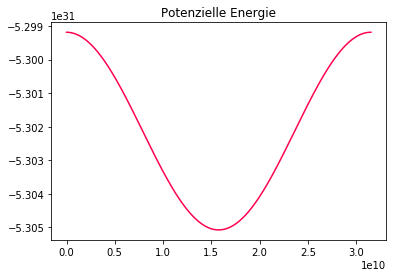

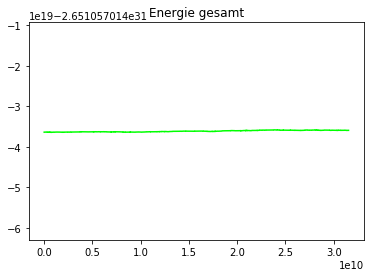

In [52]:
plot_energie(result)

In [53]:
m_e = 5.972e24
a_ort_e = np.array([149.6e11, 0.])
a_gesch_e = np.array([0.0, 29.78e3])

m_s = 1.989e30
a_ort_s = np.array([0, 0.])
a_gesch_s = np.array([0., 0.])
G_val = 6.674E-11

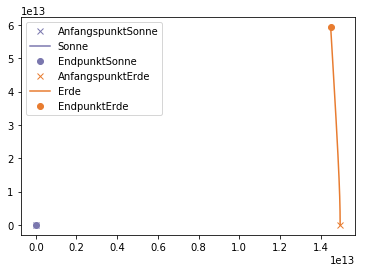

In [54]:
Namen = ['Sonne', 'Erde']
Orte = [a_ort_s, a_ort_e]
Gesch = [a_gesch_s, a_gesch_e]
Massen = [m_s, m_e]
ys, ts, c = planetsPlot(Namen, Orte, Gesch, Massen, [0, 2e9], 10000)

In [55]:
result = conservation(ys, ts)

C:\Users\ALI\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in double_scalars


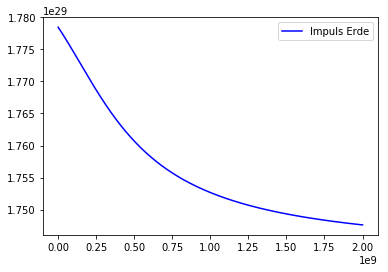

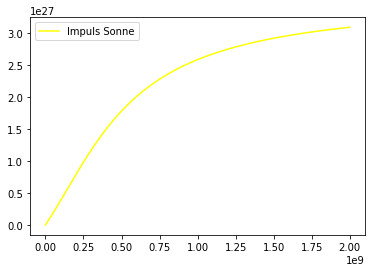

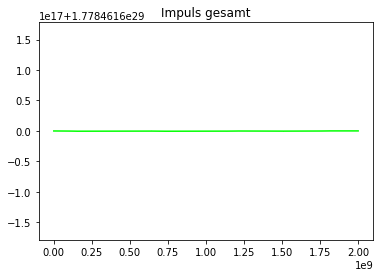

In [56]:
plot_momentum(result)

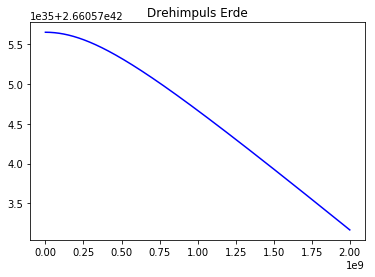

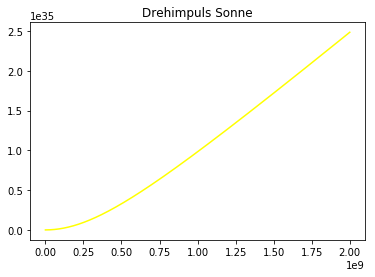

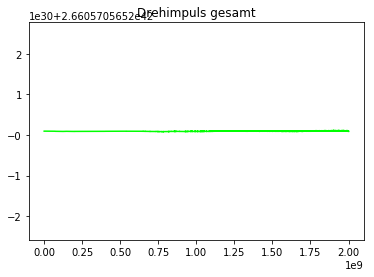

In [57]:
plot_angular_momentum(result)

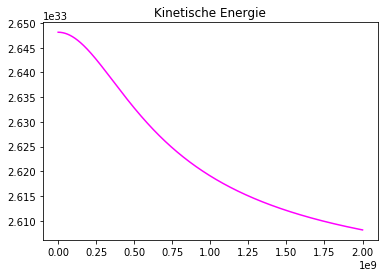

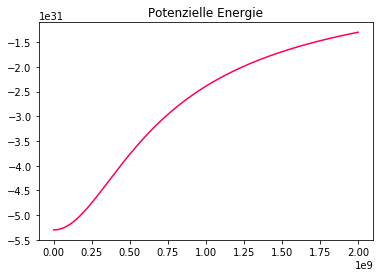

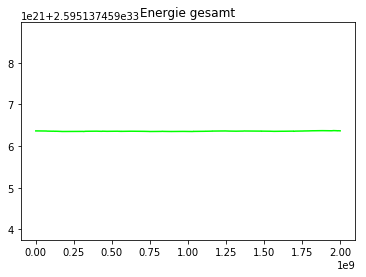

In [58]:
plot_energie(result)

In [35]:
def Bahnkurve_Animation(Anfangsorte, Anfangsgesch, masses, t0, tend, h):
    re = np.array(Anfangsorte[0])
    rs = np.array(Anfangsorte[1])
    ve = np.array(Anfangsgesch[0])
    vs = np.array(Anfangsgesch[1])
    
    scene = vp.canvas(title='Bahnkurve Erde', background=vp.color.black, forward=vec(0, 2, -1))
    erde = vp.sphere(pos=vec(re[0], re[1], 0), radius=1e12, color=vp.color.blue,  make_trail=True)
    sun = vp.sphere(pos=(vec(rs[0], rs[1], 0)), radius=2e12, color=vp.color.yellow)
    sunlight = vp.local_light(pos=vec(rs[0], rs[1], 0), color=vp.color.yellow)
    t = t0
    r_n = np.array([re[0], re[1], ve[0], ve[1], rs[0], rs[1], vs[0], vs[1]])
    dr_n = ODEPlanets(t0, r_n, masses)
    while t <= tend:
        vp.rate(5000)
        r_n = rk4(r_n, t, masses, h, ODEPlanets)
        erde.pos = vec(r_n[0], r_n[1], 0) 
        sun.pos = vec(r_n[4], r_n[5], 0)
        sunlight.pos = vec(r_n[4], r_n[5], 0)
        t += h

In [36]:
m_e = 5.972e24
a_ort_e = np.array([149.6e11, 0.])
a_gesch_e = np.array([0.0, 29.78e3])

m_s = 1.989e30
a_ort_s = np.array([0, 0.])
a_gesch_s = np.array([0., 0.])
G_val = 6.674E-11

In [37]:
Bahnkurve_Animation([a_ort_e, a_ort_s], [a_gesch_e, a_gesch_s], [m_e, m_s], 0, 2e9, 1e5)

<IPython.core.display.Javascript object>

In [38]:
G_val = 6.674E-11

m_e = 5.972e24
a_ort_e = np.array([149.6e11, 0.])
a_gesch_e = np.array([0.0, 2.978e3])

m_s = 1.989e30
a_ort_s = np.array([0, 0.])
a_gesch_s = np.array([0., 0.])

In [39]:
Bahnkurve_Animation([a_ort_e, a_ort_s], [a_gesch_e, a_gesch_s], [m_e, m_s], 0, 3.145e10, 1e6)

<IPython.core.display.Javascript object>

### 3.
Überprüfen Sie die Impuls-, Drehimpuls- und Energieerhaltung analytisch. Verwenden Sie dazu Polarkoordinaten und leinten Sie die Bewegungsgleichung in Polarkoordinaten her:
$$ m(\ddot{r} - r*\dot{\theta}^2) = -G\frac{mM}{r^2}$$
$$ m(r\ddot{\theta}+2\dot{r}\dot{\theta}) = 0 $$

### 4.
Varieeren Sie die Anfangsgeschwindigkeit der Erde und beschreiben Sie die verschiedenen Bahnformen, die sich ergeben.

### 5.
Beschrieben Sie mit Hilfe des Programms die Bewegung zweier Fast gleich großer Massen (Zweikörperproblem). Denken Sie an die Impulserhaltung!

### 6.
Drei Sterne seinen anfangs in Ruhe mit folgenden Massen und Positionen (arbitrary units):

|       | Masse |  x |  y |
|:-------:|:-------:|:----:|:----:|
|**Stern 1**|  150  |  3 |  1 |
|**Stern 2**|  200  | -1 | -2 |
|**Stern 3**|  250  | -1 |  1 |

(Die drei Sterne seien in der $xy$-Ebene.)

#### (a)
Zeigen Sie, dass die Bewegungsgleichung für Position $\vec{r}_1$ des ersten Sterns gegeben ist durch:
$$\ddot{\vec{r}}_1 = Gm_2\frac{\vec{r}_2-\vec{r}_1}{|\vec{r}_2-\vec{r}_1|^3} + Gm_3\frac{\vec{r}_3-\vec{r}_1}{|\vec{r}_3-\vec{r}_1|^3} $$
und stellen Sie die Gleichung für $\vec{r}_2$ und $\vec{r}_3$ der beiden anderen Sterne auf.

$$ \vec{F}_{ij} = -G\frac{m_im_j}{r^2}\vec{e}_r $$
$$ r = |\vec{r}_j - \vec{r}_i| $$
$$ \vec{e}_r = \frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|}$$

$$ \vec{F}_{ij} = -G\frac{m_im_j}{|\vec{r}_j - \vec{r}_i|^2}\frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|} = -Gm_im_j\frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|^3}$$

$$ m_i\ddot{\vec{r}}_i = \sum_{j\neq i} F_{ij} = \sum_{j\neq i} -Gm_im_j\frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|^3}$$

$$ \ddot{\vec{r}}_i = \sum_{j\neq i} -Gm_j\frac{\vec{r}_j - \vec{r}_i}{|\vec{r}_j - \vec{r}_i|^3}$$

$$ \ddot{\vec{r}}_1 = -Gm_2\frac{\vec{r}_2 - \vec{r}_1}{|\vec{r}_2 - \vec{r}_1|^3} -Gm_3\frac{\vec{r}_3 - \vec{r}_1}{|\vec{r}_3 - \vec{r}_1|^3}$$
$$ \ddot{\vec{r}}_2 = -Gm_1\frac{\vec{r}_1 - \vec{r}_2}{|\vec{r}_1 - \vec{r}_2|^3} -Gm_3\frac{\vec{r}_3 - \vec{r}_2}{|\vec{r}_3 - \vec{r}_2|^3}$$
$$ \ddot{\vec{r}}_3 = -Gm_1\frac{\vec{r}_1 - \vec{r}_3}{|\vec{r}_1 - \vec{r}_3|^3} -Gm_2\frac{\vec{r}_2 - \vec{r}_3}{|\vec{r}_2 - \vec{r}_3|^3}$$

#### (b)
Setzten Sie $G=1$ und schreiben sie ein Programm, das die Bewegungsgleichungen löst. Plotten Sie $y$ als Funktion von $x$ und animieren Sie die Bewegung. Die Sterne bewegen sich sehr schnell, wenn sie sich nähern und sind sehr langsam, wenn sie weit voneinander entfernt sind. Eine adaptive Methode könnte deshab nützlich sein.

In [40]:
G = 1

In [41]:
def ODEstars(y, t):
    '''
    berechnet die rechte Seite der Differentialgleichung 
    Zunächst kommen alle Variablen (x,y,vx,vy) für den ersten Planeten, dann alle 4 für den zweiten,... 
    :param t: aktueller zeitpunkt
    :param y: aktueller y-Wert (n Komponenten)
    :return: rechte Seite f der Dgl. y'=f(t,y)
    '''

    # Daten der Planeten
    G = 1  # Gravitationskonstante
    y = np.array(y)
    y = y.reshape(-1, 4)
    #print(y)
    rs = []
    dy = []
    #print(planets)
    for i in range(0, len(y)):
        F_i = 0
        rs.append(np.array([y[i][0], y[i][1]]))
        r_i = np.array([y[i][0], y[i][1]])
        for j in range(0, len(y)):
            if i != j:
                r_j = np.array([y[j][0], y[j][1]])
                m_j = masses[j]
                dist = r_i-r_j
                F_i += m_j *((dist)/(LA.norm(dist))**3)
        ddr_i = -G*F_i
        dy.append(y[i][2])
        dy.append(y[i][3])
        dy.append(ddr_i[0])
        dy.append(ddr_i[1])
    return dy

In [42]:
def starsCoordinates(stars, t0, tend, N):
    star_n = []
    tvals, h = np.linspace(t0, tend, N, retstep=True)
    #print(h)
    coordinates = {}
    y_stars = []
    for star in stars:
        star_n.append(star)
        x_s = stars[star]['pos'][0]
        y_s = stars[star]['pos'][1]
        vx_s = stars[star]['vel'][0]
        vy_s = stars[star]['vel'][1]
        y_stars.append(x_s)
        y_stars.append(y_s)
        y_stars.append(vx_s)
        y_stars.append(vy_s)
        coordinates[star] = {'x':[], 'y':[]}
    y_list = [y_stars]
    y_list = integrate.odeint(ODEstars, y_stars, tvals)
    y_list[0] = np.array(y_list[0])
    for y_step in y_list:
        y_shaped = y_step.reshape(-1, 4)
        for i in range(0, len(y_shaped)):
            list_c = coordinates[star_n[i]]['x']
            list_c.append(y_shaped[i][0])
            list_c = coordinates[star_n[i]]['y']
            list_c.append(y_shaped[i][1])
    
    return coordinates

In [43]:
def starsPlot(stars, t0, tend, N):
    coordinates = starsCoordinates(stars, t0, tend, N)
    for st in coordinates:
        r = np.random.rand()
        g = np.random.rand()
        b = np.random.rand()
        xs = coordinates[st]['x']
        ys = coordinates[st]['y']
        #plt.plot(xs[0], ys[0], 'o', color=[r, g, b])
        plt.plot(xs, ys, color=[r, g, b], label=st)
        plt.plot(xs[-1], ys[-1], 'o', color=[r, g, b])
        plt.plot(xs[0], ys[0], 'x', color=[r, g, b])

    plt.legend()
    plt.show()

In [44]:
s1 = {'pos': [ 3,  1], 'vel': [0, 0]}
s2 = {'pos': [-1, -2], 'vel': [0, 0]}
s3 = {'pos': [-1,  1], 'vel': [0, 0]}
Sterne = {'Stern1': s1, 'Stern2': s2, 'Stern3': s3}
masses = [150, 200, 250]

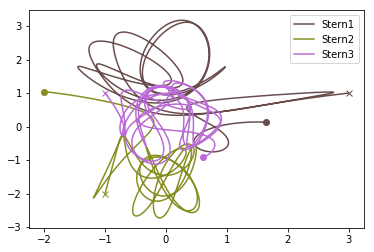

In [45]:
starsPlot(Sterne, 0, 5, 10000)

In [46]:
s1 = {'pos': [ 0,  2], 'vel': [-0.4, -0.4]}
s2 = {'pos': [ 1,  1], 'vel': [-3, -3]}
s3 = {'pos': [-1,  1], 'vel': [3, 3]}
Sterne = {'Stern1': s1, 'Stern2': s2, 'Stern3': s3}
masses = [1, 200, 200]


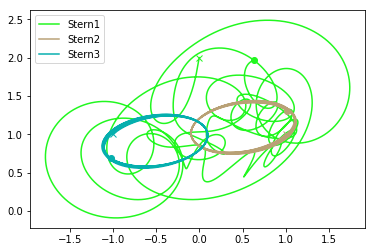

In [47]:
starsPlot(Sterne, 0, 2.4, 100000)

In [54]:
s1 = {'pos': [ 0,  2], 'vel': [0, 0]}
s2 = {'pos': [ 1,  1], 'vel': [0, -90]}
s3 = {'pos': [0,  1], 'vel': [0, 0]}
Sterne = {'Stern1': s1, 'Stern2': s2, 'Stern3': s3}
masses = [10, 200, 20000]

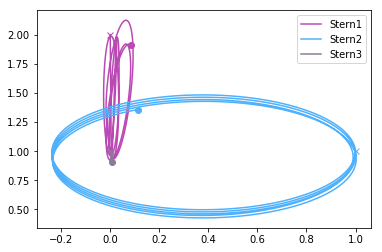

In [55]:
starsPlot(Sterne, 0, 0.1, 100000)

In [74]:
s1 = {'pos': [ 3,  1], 'vel': [2, -5]}
s2 = {'pos': [-1, -2], 'vel': [5, 2]}
s3 = {'pos': [-1,  1], 'vel': [-2, 5]}
Sterne = {'Stern1': s1, 'Stern2': s2, 'Stern3': s3}
masses = [150, 200, 250]

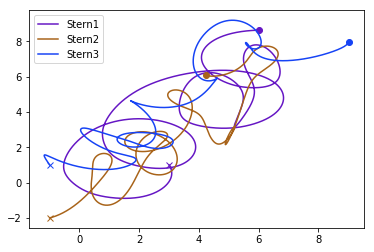

In [76]:
starsPlot(Sterne, 0, 5, 100000)

In [77]:
def starsAnimation(stars, t0, tend, N, Rate):
    
    scene = vp.canvas(title='Animation Sterne', background=vp.color.black, forward=vec(0, 2, -1))
    stern1 = vp.sphere(pos=vec(stars['Stern1']['pos'][0], stars['Stern1']['pos'][1], 0), radius=0.1, color=vp.color.blue, make_trail=True)
    stern2 = vp.sphere(pos=vec(stars['Stern2']['pos'][0], stars['Stern2']['pos'][1], 0), radius=0.1, color=vp.color.green, make_trail=True)
    stern3 = vp.sphere(pos=vec(stars['Stern3']['pos'][0], stars['Stern3']['pos'][1], 0), radius=0.1, color=vp.color.yellow, make_trail=True)
    coordinates = starsCoordinates(stars, t0, tend, N)
    h = abs(tend-t0)/N
    t = t0
    i = 0
    while i < len(coordinates['Stern1']['x']):
        s1 = coordinates['Stern1']
        s2 = coordinates['Stern2']
        s3 = coordinates['Stern3']
        vp.rate(Rate)
        stern1.pos = vec(s1['x'][i], s1['y'][i],0)
        stern2.pos = vec(s2['x'][i], s2['y'][i],0)
        stern3.pos = vec(s3['x'][i], s3['y'][i],0)
        i += 1

In [78]:
s1 = {'pos': [ 3,  1], 'vel': [0, 0]}
s2 = {'pos': [-1, -2], 'vel': [0, 0]}
s3 = {'pos': [-1,  1], 'vel': [0, 0]}
Sterne = {'Stern1': s1, 'Stern2': s2, 'Stern3': s3}
masses = [150, 200, 250]

In [79]:
starsAnimation(Sterne, 0, 3, 100000, 1000)

<IPython.core.display.Javascript object>

In [81]:
s1 = {'pos': [ 0,  2], 'vel': [-0.4, -0.4]}
s2 = {'pos': [ 1,  1], 'vel': [-3, -3]}
s3 = {'pos': [-1,  1], 'vel': [3, 3]}
Sterne = {'Stern1': s1, 'Stern2': s2, 'Stern3': s3}
masses = [1, 200, 200]

In [82]:
starsAnimation(Sterne, 0, 4, 100000, 500)

<IPython.core.display.Javascript object>

In [83]:
s1 = {'pos': [ 0,  1], 'vel': [0, 9]}
s2 = {'pos': [ 1,  1], 'vel': [0, 7]}
s3 = {'pos': [-1,  1], 'vel': [0, 0]}
Sterne = {'Stern1': s1, 'Stern2': s2, 'Stern3': s3}
masses = [2, 2, 200]

In [84]:
starsAnimation(Sterne, 0, 1, 100000, 900)

<IPython.core.display.Javascript object>

In [168]:
s1 = {'pos': [ -1,  0], 'vel': [7, 5]}
s2 = {'pos': [-1, -3], 'vel': [-5, 2]}
s3 = {'pos': [3,  -1], 'vel': [-1, -7]}
Sterne = {'Stern1': s1, 'Stern2': s2, 'Stern3': s3}
masses = [200, 200, 200]

In [169]:
starsAnimation(Sterne, 0, 4, 100000, 500)

<IPython.core.display.Javascript object>